In [62]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [63]:
cd /home/chenxupeng/projects/DIP

/home/chenxupeng/projects/DIP


In [64]:
ls output/models/cr_softmax/

beta.txt  J_loss.txt  no_l1/  W.txt


In [53]:
beta_path = 'output/models/cr_softmax/'
w_path = 'output/models/cr_softmax/'
betas = np.loadtxt(beta_path+'beta.txt')
W = np.loadtxt(w_path+'W.txt')

In [54]:
betas.shape

(50, 10)

In [65]:
def plot_beta_W(path,row_num=2):
    #beta_path = 'output/models/cr_softmax/'
    #w_path = 'output/models/cr_softmax/'
    
    betas = np.loadtxt(path+'beta.txt')
    W = np.loadtxt(path+'W.txt')
    beta_num = betas.shape[0]
    pal = sns.color_palette("Greens_d", beta_num)
    fig,ax=plt.subplots(row_num,5,figsize=(40,8))
    for i in range(5):
        for j in range(row_num):
            rank = np.abs(betas[i+j*2]).ravel().argsort().argsort()  
            sns.barplot(data=pd.DataFrame(np.concatenate((np.arange(0,beta_num).reshape(-1,1),
                                                  betas[:,i+j*row_num].reshape(-1,1)),axis=1) ),x=0,y=1,
                                                 palette=np.array(pal[::-1])[rank],ax=ax[j,i])
    fig,ax=plt.subplots(1,figsize=(6,3))
    sns.distplot(W,ax=ax)
    return betas

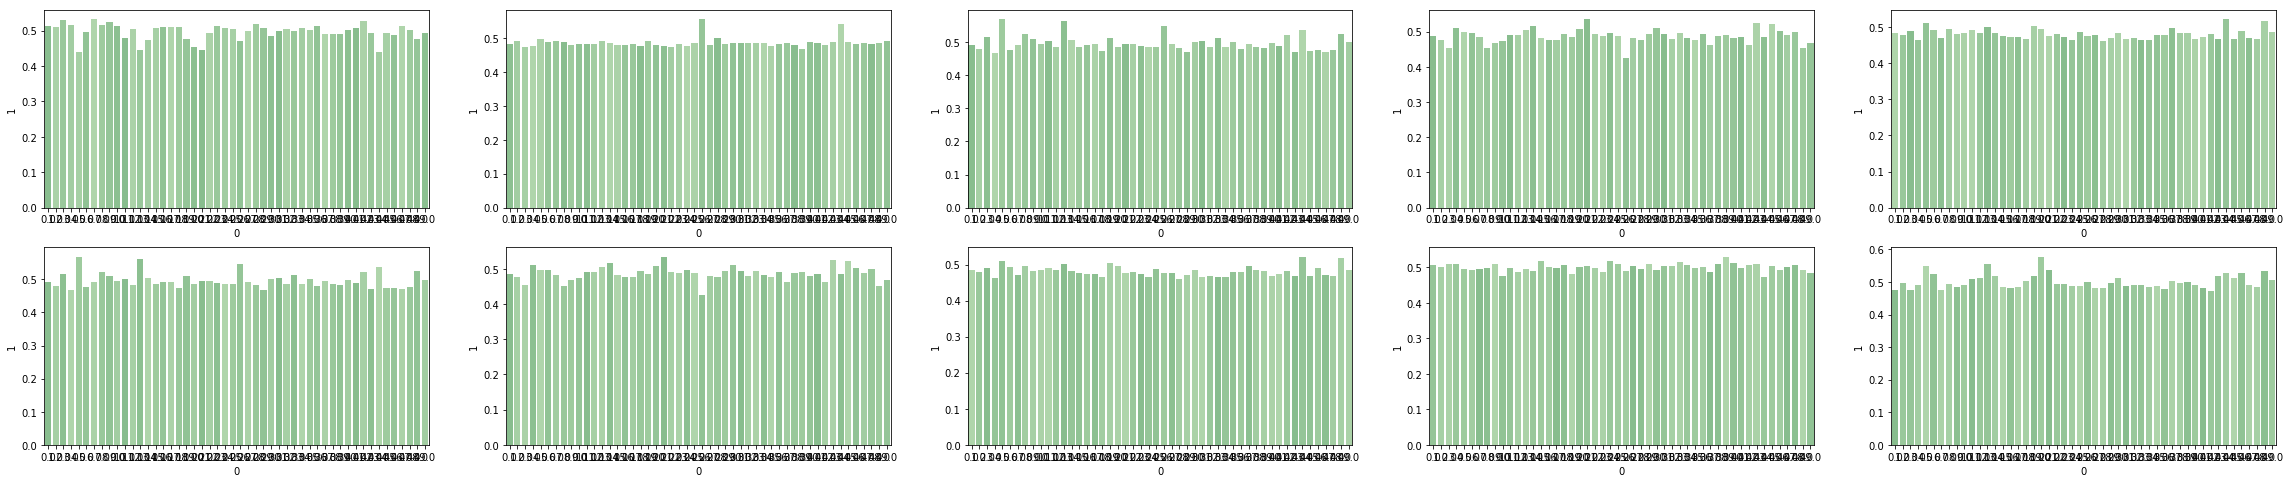

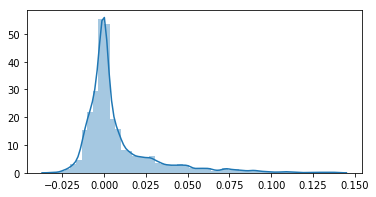

In [66]:
betas = plot_beta_W('output/models/cr_softmax/')

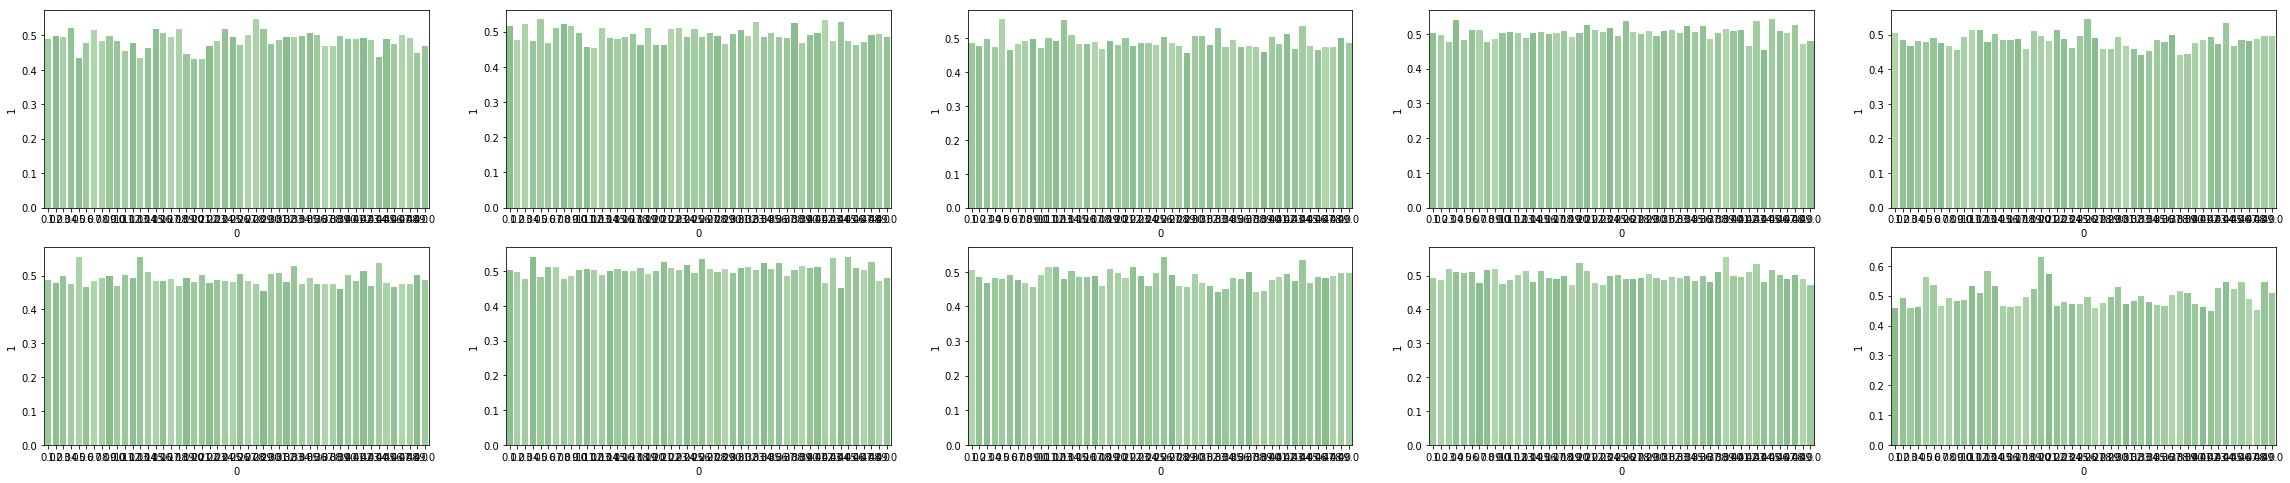

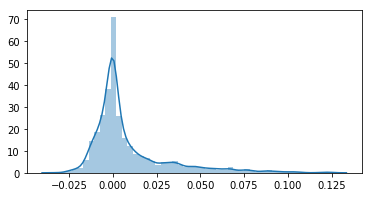

In [71]:
bates_nol1 = plot_beta_W('output/models/cr_softmax/no_l1/')

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
def prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'classic',train_context_num=5):
    import scipy.io as sio
    BoW_Training = sio.loadmat(datafile)['data']
    #print (BoW_Training.shape)
    BoW_Training_x = BoW_Training[:,:50]
    BoW_Training_y = BoW_Training[:,-2:]
    if valid_method == 'classic':
        return train_test_split(BoW_Training_x, BoW_Training_y, test_size=0.2, random_state=42)
    elif valid_method =='non-iid':
        '''
        split the dataset so for each class, split 7 contexts into 5:2, 
        predict 2 contexts corresponding class
        '''
        tmp_select_ind = np.array([]).astype('int')
        for i in np.unique(BoW_Training_y[:,0]):
            #print (np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]))
            tmp_context_ind = np.random.choice(np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]),
                            train_context_num,replace=False,)
            tmp_select_ind = np.concatenate((tmp_select_ind,np.where( (BoW_Training_y[:,0]==i)& 
                                (np.isin(BoW_Training_y[:,1],tmp_context_ind )==1) )[0]  ))

        train_ind = tmp_select_ind
        test_ind = np.setdiff1d(np.arange(0,BoW_Training_y.shape[0]),tmp_select_ind)
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore')
        y = enc.fit_transform(BoW_Training_y[:,0].reshape(-1,1)).toarray()
        return BoW_Training_x[train_ind],BoW_Training_x[test_ind],y[train_ind],\
                y[test_ind],train_ind,test_ind
X_train, X_test, y_train, y_test,_,_ = prepare_dataset(datafile='data/BoW_Training.mat',
                                                    valid_method = 'non-iid',
                                                    train_context_num=5)
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))
#y_train,y_test = y_train[:,0].reshape(-1,1),y_test[:,0].reshape(-1,1)
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler
X_train = preprocess(X_train,method='robust')[0]
X_test =  preprocess(X_test,method='robust')[0]

number of training samples: 2976, test samples: 1180


In [68]:
eps=1e-3
def sigmoid(x):
    #z = np.dot(X,W)
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x,axis=1)
    sum_exp_x= sum_exp_x.reshape((x.shape[0],1))
    sigmoid = exp_x / (sum_exp_x+eps**3)
    #print ('sigmoid',exp_x,sum_exp_x)
    return sigmoid
def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average=None),
           'precision': precision_score(y_test, y_pred,average=None),
           'f1': f1_score(y_test, y_pred,average=None),
           'mcc': matthews_corrcoef(y_test, y_pred)
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))
    return scorers['f1'],scorers['accuracy'],scorers['recall'],scorers['precision'],scorers['mcc']
def report_metrics_plot(y_test, y_pred):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

accuracy = 0.18898305084745762
recall = [0.1        0.15       0.05       0.325      0.26666667 0.03333333
 0.4        0.075      0.53       0.01666667]
precision = [0.16438356 0.38297872 0.20689655 0.13087248 0.22695035 0.16666667
 0.16724739 0.375      0.21544715 0.18181818]
f1 = [0.12435233 0.21556886 0.08053691 0.18660287 0.24521073 0.05555556
 0.23587224 0.125      0.30635838 0.03053435]
mcc = 0.1062299140506722


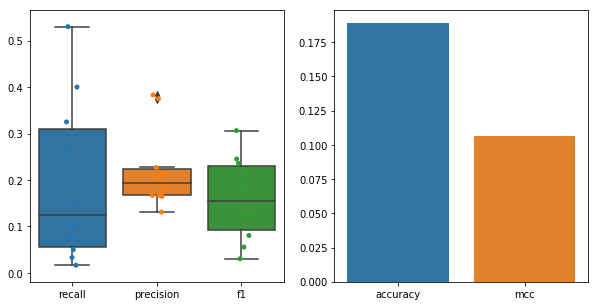

In [72]:
y_pred = np.argmax(sigmoid(np.dot(X_test,bates_nol1)),axis=1)
report_metrics_plot(np.where(y_test==1)[1], y_pred)

accuracy = 0.16186440677966102
recall = [0.20833333 0.01666667 0.09166667 0.075      0.5        0.01666667
 0.36666667 0.18333333 0.08       0.06666667]
precision = [0.23809524 0.05128205 0.088      0.16363636 0.17751479 0.05714286
 0.20276498 0.18487395 0.07142857 0.22857143]
f1 = [0.22222222 0.02515723 0.08979592 0.10285714 0.26200873 0.02580645
 0.2611276  0.18410042 0.0754717  0.10322581]
mcc = 0.07102852383402437


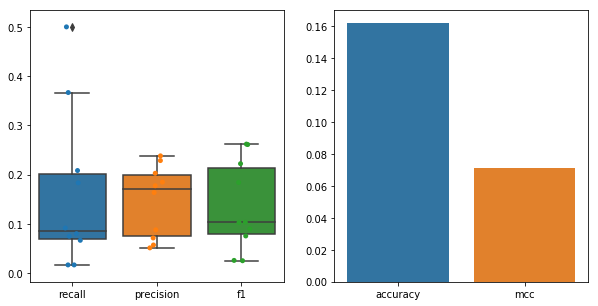

In [73]:
y_pred = np.argmax(sigmoid(np.dot(X_test,betas)),axis=1)
report_metrics_plot(np.where(y_test==1)[1], y_pred)

In [6]:
betas = {}
W = {}
for i in range(10):
    betas[i] = np.load(beta_path+'beta'+str(i)+'.npy')
    W[i] = np.load(w_path+'w'+str(i)+'.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'output/models/cr_softmax/beta0.npy'

NameError: name 'beta_num' is not defined

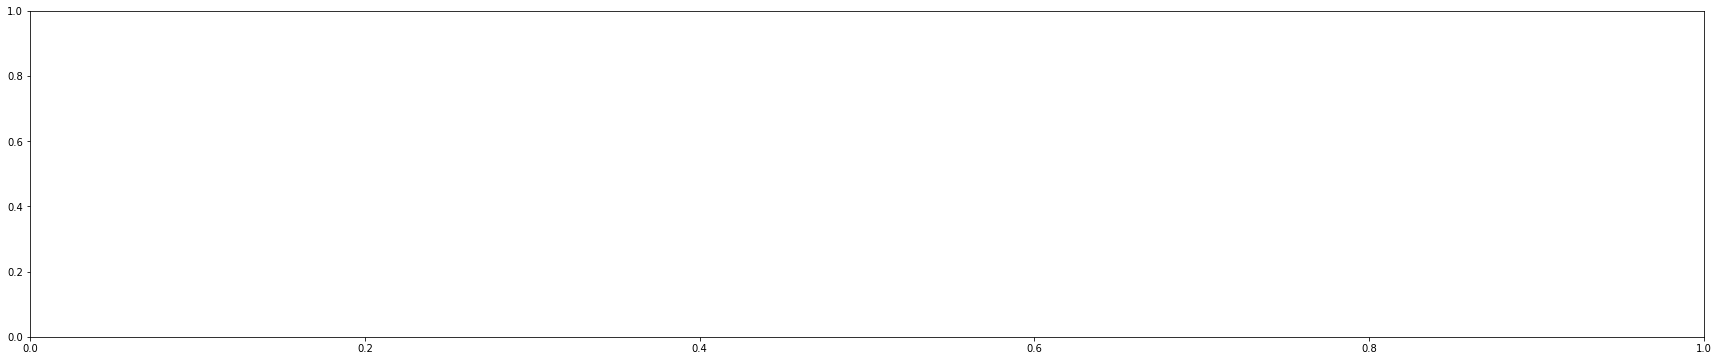

In [7]:
fig,ax=plt.subplots(1,figsize=(30,6))
sns.barplot(data=pd.DataFrame(np.concatenate((np.arange(0,beta_num).reshape(-1,1),
                                              betas[0].reshape(-1,1)),axis=1) ),x=0,y=1,
                                             palette=np.array(pal[::-1])[rank],ax=ax)

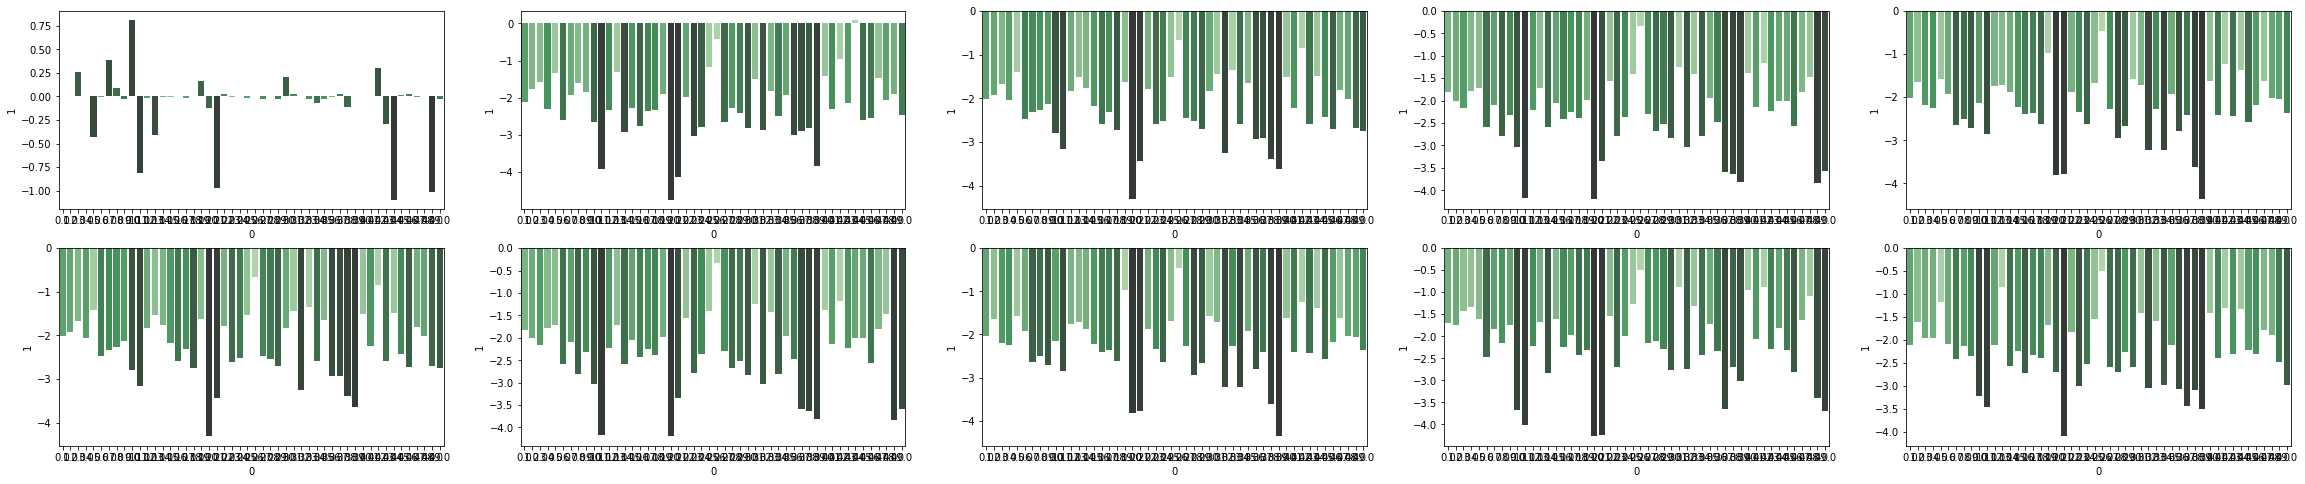

In [6]:
beta_num = betas[0].shape[0]
pal = sns.color_palette("Greens_d", beta_num)
fig,ax=plt.subplots(2,5,figsize=(40,8))
for i in range(5):
    for j in range(2):
        rank = np.abs(betas[i+j*2]).ravel().argsort().argsort()  
        sns.barplot(data=pd.DataFrame(np.concatenate((np.arange(0,beta_num).reshape(-1,1),
                                              betas[i+j*2].reshape(-1,1)),axis=1) ),x=0,y=1,
                                             palette=np.array(pal[::-1])[rank],ax=ax[j,i])

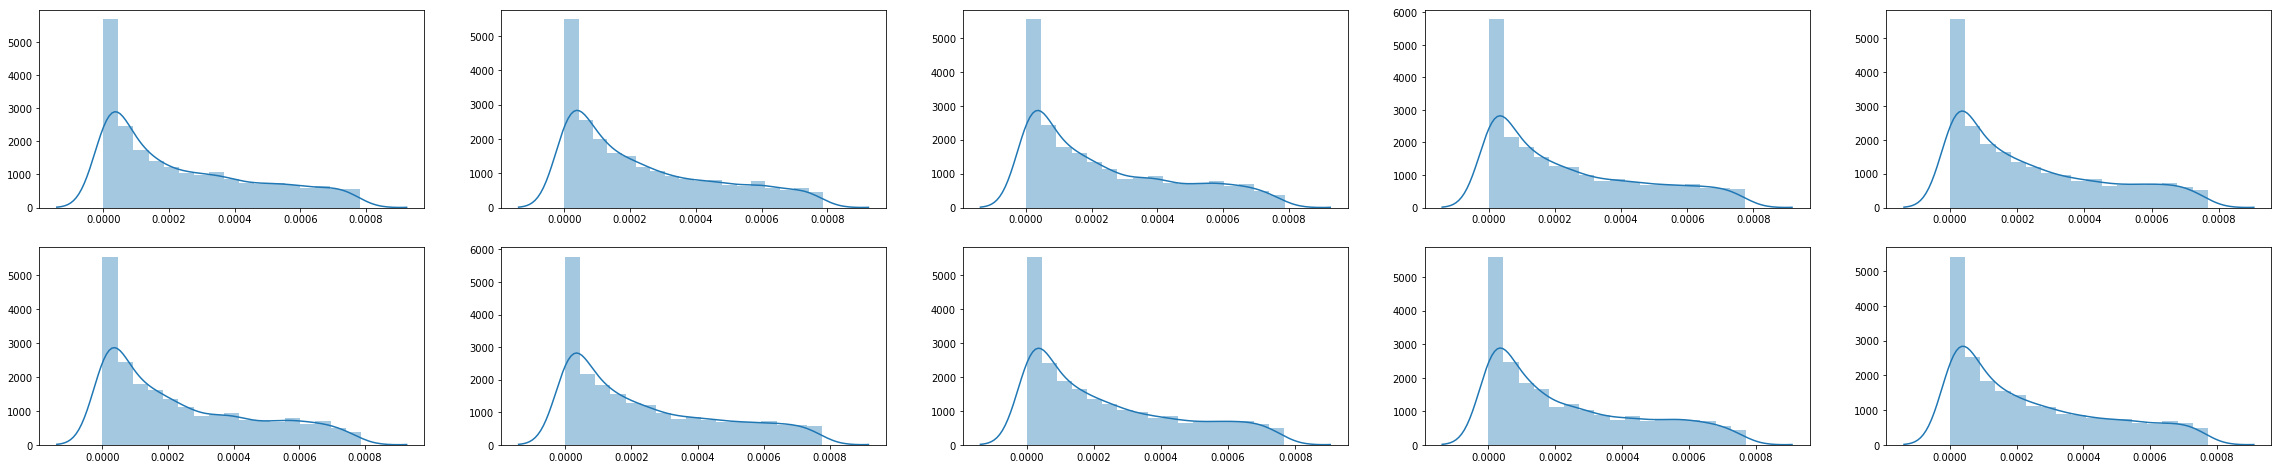

In [8]:
fig,ax=plt.subplots(2,5,figsize=(40,8))
for i in range(5):
    for j in range(2):
        sns.distplot(W[i+j*2],ax=ax[j,i])

In [9]:
W_df = pd.DataFrame(np.concatenate([v for k,v in sorted(W.items())], 1))

In [10]:
W_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03
mean,2.438938e-04,2.396413e-04,2.393046e-04,2.424239e-04,2.391140e-04,2.386025e-04,2.412248e-04,2.420386e-04,2.421412e-04,2.410885e-04
std,2.280956e-04,2.236750e-04,2.243276e-04,2.271892e-04,2.217144e-04,2.226347e-04,2.225026e-04,2.228686e-04,2.263446e-04,2.247004e-04
min,5.280616e-12,2.131151e-10,1.615278e-10,1.552436e-10,2.398389e-12,1.108797e-10,6.330703e-12,6.861292e-11,8.138504e-12,1.876363e-11
25%,4.250468e-05,4.705574e-05,4.340084e-05,4.150404e-05,4.494936e-05,4.314460e-05,4.657606e-05,4.441251e-05,4.248043e-05,4.285342e-05
50%,1.667415e-04,1.705989e-04,1.664628e-04,1.692371e-04,1.681941e-04,1.625962e-04,1.723454e-04,1.757991e-04,1.712509e-04,1.702374e-04
75%,4.053146e-04,3.951526e-04,3.997386e-04,4.063116e-04,3.962504e-04,4.061046e-04,3.975066e-04,4.117499e-04,3.998416e-04,4.030036e-04
max,7.823297e-04,7.866397e-04,7.876946e-04,7.758624e-04,7.668663e-04,7.698241e-04,7.732842e-04,7.643389e-04,7.915583e-04,7.809662e-04


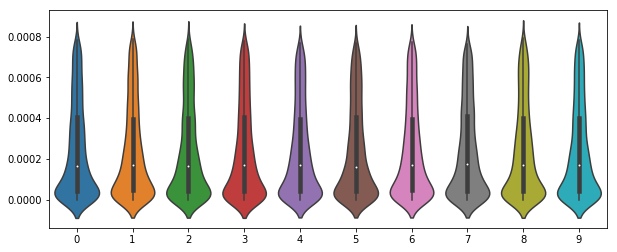

In [11]:
fig,ax=plt.subplots(1,figsize=(10,4))
sns.violinplot(data=W_df,ax=ax)

W_df['index'] = W_df.index
W_df_all = W_df.melt(id_vars=['index'])
W_df_all.head()